import libraries

In [1]:
import numpy as np #numpy for math operation
import os
from utils import load_nested_data_pickle
import matplotlib.pyplot as plt
import cv2 
from scipy.optimize import curve_fit
from time import time

In [2]:
data_path = "D:/globus slate shared data Tankam Lab/without_H2O2_registered_cropped_top/"
image_list = os.listdir(data_path)#list all images address in data_path

fourD_image_volume_complete = load_nested_data_pickle(data_path, len(image_list))#load all image volume and combine them in one 4D np array

In [3]:
fourD_image_volume_complete.shape

(25, 500, 100, 454)

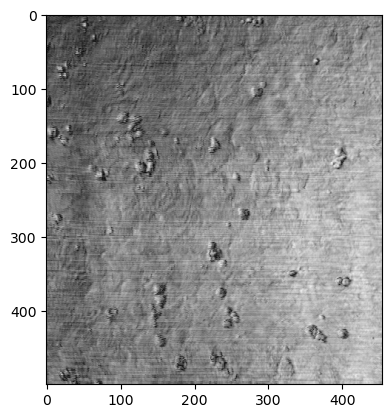

In [4]:
full_image = cv2.normalize(fourD_image_volume_complete[10, :, 35, :], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
plt.imshow(full_image, cmap="gray")

In [8]:
data_path = "D:/globus slate shared data Tankam Lab/without_H2O2_registered_cropped_top/"
image_list = os.listdir(data_path)#list all images address in data_path

fourD_image_volume = fourD_image_volume_complete[:, :, 35:36, :]#load all image volume and combine them in one 4D np array
fourD_shape = fourD_image_volume.shape#float type 32
number_of_scan = fourD_shape[0]


time_index_list = []#create a list that will store both time interval and list that contain scan index comform the time interval
for i in range(1, number_of_scan, 1):
    time_interval = i
    index_list = []
    desirable_len = len(list(range(0, number_of_scan, time_interval)))
    for j in range(time_interval):
        candidate_index = list(range(j, number_of_scan, time_interval))
        if len(candidate_index) == desirable_len:
            index_list.append(candidate_index)#avoid the case when the length of index array is short
    time_index_list.append([time_interval, index_list])

In [7]:
def AVG_LIV(oneD_data, time_index_list):
    log_data = 10 * np.log10(oneD_data + 1e-8)#convert the intensity to log data, add small number to prevent 0 from occuring  
    time_avgLIV = np.zeros((len(time_index_list), 2))#data structure to store time interval and its avgLIV
    for i in range(len(time_index_list)):
        index_data_group = time_index_list[i][1]
        num_data_group = len(index_data_group)#number of data groups that belong to this specific time interval
        LIV_group = np.zeros(num_data_group)
        for j in range(num_data_group):
            sub_log_data = log_data[index_data_group[j]]
            avglog = np.sum(sub_log_data) / (np.max(index_data_group[j])-np.min(index_data_group[j]))#time average of LIV
            sub_log_substraction = sub_log_data - avglog
            sub_LIV = np.mean(np.square(sub_log_substraction))#LIV of this particular sub dataset
            # sub_LIV = np.nanvar(sub_log_data)
            LIV_group[j] = sub_LIV
        time_avgLIV[i, :] = [time_index_list[i][0], np.mean(LIV_group)]#the average LIV of this particular time interval
    return time_avgLIV
            





In [7]:
test_oneD = fourD_image_volume[:, 9, 9, 2]
Average_LIV = AVG_LIV(test_oneD, time_index_list)
plt.plot(Average_LIV[:, 0], Average_LIV[:, 1])
plt.xlabel("Tw")
plt.ylabel("AVG_LIV")

NameError: name 'fourD_image_volume' is not defined

curve fiting for this particular LIV curve

In [28]:
def LIV_fun(Tw, a, tau):
    return a * (1 - np.exp(-Tw / tau))

#function in multiprocessing

def LIV_multiprocess(shared_array, shape, i, j, k, time_lapse_string, time_index_list):
    array_2d = np.frombuffer(shared_array.get_obj()).reshape(shape)
    Average_LIV = AVG_LIV(time_lapse_string, time_index_list)
    Average_LIV[~np.isfinite(Average_LIV)] = np.mean(Average_LIV[np.isfinite(Average_LIV)])#remove infinity and NaN
    popt = curve_fit(LIV_fun, Average_LIV[:, 0], Average_LIV[:, 1], bounds=(0, np.inf))[0]
    array_2d[i, j, k] = 1 / popt[1]



create a 3 dimensional array to store swiftness data of every voxel in the set

In [58]:
# if __name__ == "__main__":
#     tic = time()

#     data_path = "D:/globus slate shared data Tankam Lab/without_H2O2_registered_cropped_top/"
#     image_list = os.listdir(data_path)#list all images address in data_path

#     fourD_image_volume = load_nested_data_pickle(data_path, 4)#load all image volume and combine them in one 4D np array
#     fourD_shape = fourD_image_volume.shape#float type 32
#     number_of_scan = fourD_shape[0]


#     time_index_list = []#create a list that will store both time interval and list that contain scan index comform the time interval
#     for i in range(1, number_of_scan, 1):
#         time_interval = i
#         index_list = []
#         desirable_len = len(list(range(0, number_of_scan, time_interval)))
#         for j in range(time_interval):
#             candidate_index = list(range(j, number_of_scan, time_interval))
#             if len(candidate_index) == desirable_len:
#                 index_list.append(candidate_index)#avoid the case when the length of index array is short
#         time_index_list.append([time_interval, index_list])


#     #create shared swifit map for storing all the swifit value
#     shared_map = multiprocessing.Array("d", fourD_shape[1]*fourD_shape[2]*fourD_shape[3])
#     shared_shape = (fourD_shape[1],fourD_shape[2],fourD_shape[3])
#     swift_map = np.frombuffer(shared_map.get_obj()).reshape(shared_shape)
#     swift_map[:] = 0
#     #create and start multiple process to modify the shared memory
#     processse = []
#     for i in range(fourD_shape[1]):
#         for j in range(fourD_shape[2]):
#             for k in range(fourD_shape[3]):
#                 time_lapse_string = fourD_image_volume[:, i, j, k]
#                 p = multiprocessing.Process(target=LIV_multiprocess, args=(shared_map, shared_shape, i, j, k, time_lapse_string, time_index_list))
#                 processse.append(p)
#                 p.start()

#     for p in processse:
#         p.join()
    
#     toc = time()

#     array_normalized = cv2.normalize(swift_map[15, 280, :, :], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

tic = time()
wshape = (fourD_shape[1], fourD_shape[2], fourD_shape[3])
swift_map = np.zeros(wshape)
for i in range(fourD_shape[1]):
    for j in range(fourD_shape[2]):
        for k in range(fourD_shape[3]):
            time_lapse_string = fourD_image_volume[:, i, j, k]
            Average_LIV = AVG_LIV(time_lapse_string, time_index_list)
            Average_LIV[~np.isfinite(Average_LIV)] = np.mean(Average_LIV[np.isfinite(Average_LIV)])#remove infinity and NaN
            popt = curve_fit(LIV_fun, Average_LIV[:, 0], Average_LIV[:, 1], bounds=(0, np.inf))[0]
            swift_map[i, j, k] = 1 / popt[1]


#array_normalized = cv2.normalize(swift_map[15, 280, :, :], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

tic = time()
            

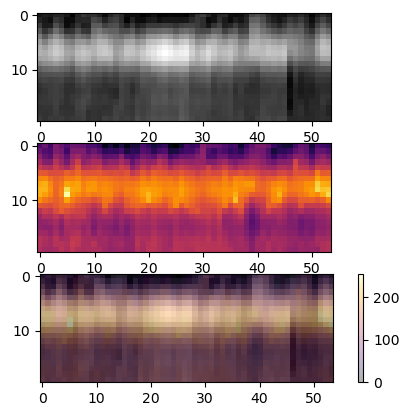

In [70]:
swift_normalized = cv2.normalize(swift_map[5, :, :,], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
fourD_normalized = cv2.normalize(fourD_image_volume[10, 5, :, :], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20, 60), ncols=3)
# fo = ax1.imshow(fourD_normalized, cmap="gray")
# sw = ax2.imshow(swift_normalized, cmap="inferno")
# co_n = ax3.imshow(fourD_normalized, cmap="gray")
# co_s = ax3.imshow(swift_normalized, cmap="inferno", alpha = 0.4)
# fig.colorbar(co_s, ax=ax3)

plt.subplot(3, 1, 1)
plt.imshow(fourD_normalized, cmap="gray")
plt.subplot(3, 1, 2)
plt.imshow(swift_normalized, cmap="inferno")
plt.subplot(3, 1, 3)
plt.imshow(fourD_normalized, cmap="gray")
plt.imshow(swift_normalized, cmap="inferno", alpha=0.3)
plt.colorbar()
# fourD_shape[1]

enface view

In [5]:
with open("swift.npy", "rb") as f:
    swift = np.load(f)

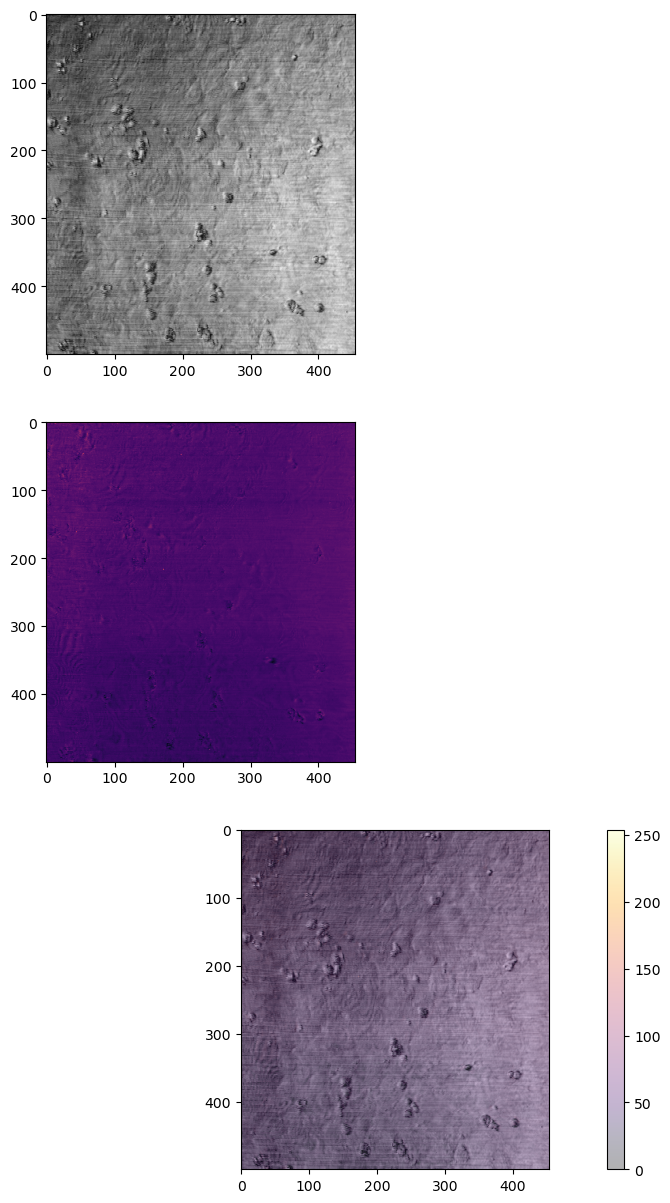

In [9]:
depth = 0
swift_normalized = cv2.normalize(swift[:, depth, :,], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
fourD_normalized = cv2.normalize(fourD_image_volume[10, :, depth, :], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# plt.subplot(3, 1, 1)
# plt.imshow(fourD_normalized, cmap="gray")
# plt.subplot(3, 1, 2)
# plt.imshow(swift_normalized, cmap="inferno")
# plt.subplot(3, 1, 3)
# plt.imshow(fourD_normalized, cmap="gray")
# plt.imshow(swift_normalized, cmap="inferno", alpha=0.3)
# plt.colorbar()

f = plt.figure(figsize=(15, 15))
ax = f.add_subplot(311)
ax2 = f.add_subplot(312)
ax3 = f.add_subplot(313)
ax.imshow(fourD_normalized, cmap="gray")
ax2.imshow(swift_normalized, cmap="inferno")
ax3.imshow(fourD_normalized, cmap="gray")
smap = ax3.imshow(swift_normalized, cmap="inferno", alpha=0.3)
f.colorbar(smap)